In [23]:
import sys
print(sys.executable)

/home/21101405/miniconda3/bin/python


In [25]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import xarray as xr
from matplotlib.lines import Line2D
# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

## Load the data: for Date of Simulations
- 22 May- L2 Loss (MSE Loss function)

In [36]:
sat_chl=xr.open_dataset("/A04/so_data/Trend_paper/CNN_training/obs/Same_grid_CHL_25km_masked.nc")
pred_chl= xr.open_mfdataset("/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-23/*Chloro_pred/Chloro_pred_*.nc").load()

In [37]:
### Make Same time period 
sat_chl=sat_chl.sel(time=pred_chl.time)
sat_chl

<xarray.Dataset> Size: 958MB
Dimensions:    (time: 252, latitude: 220, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2003-01-31 2003-02-28 ... 2023-12-31
  * latitude   (latitude) float64 2kB -30.0 -30.25 -30.5 ... -84.25 -84.5 -84.75
  * longitude  (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    mask       (time, latitude, longitude) float64 639MB ...
Data variables:
    CHL        (time, latitude, longitude) float32 319MB ...
Attributes:
    regrid_method:  bilinear

In [28]:
## Let's do the corleations
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Stack spatial dims for vectorized correlation
stacked_sat = sat_chl.stack(z=("latitude", "longitude"))  # Collapse 'latitude' and 'longitude' into a single dimension 'z' for satellite chlorophyll
stacked_pred = pred_chl.stack(z=("latitude", "longitude"))  # Same stacking for predicted chlorophyll

# Convert to numpy
x = stacked_sat.CHL.transpose("z", "time").values  # Reorder to (z, time) and convert to NumPy for satellite data
y = stacked_pred.chloro_pred.transpose("z", "time").values  # Reorder to (z, time) and convert to NumPy for predicted data

# Preallocate correlation array
corrs = np.full(x.shape[0], np.nan)  # Create an array of NaNs to store correlation values, one per spatial point

# Compute correlation across time for each spatial point
for i in range(x.shape[0]):  # Loop over all spatial points (flattened)
    xi = x[i]  # Time series of satellite data at location i
    yi = y[i]  # Time series of predicted data at location i
    mask = ~np.isnan(xi) & ~np.isnan(yi)  # Create mask where both xi and yi are not NaN
    if np.count_nonzero(mask) > 1:  # Check if there are at least 2 valid time points to compute correlation
        corrs[i] = np.corrcoef(xi[mask], yi[mask])[0, 1]  # Compute Pearson correlation and store it

# Convert back to xarray
corr_map = xr.DataArray(corrs, coords=[stacked_sat["z"]]).unstack("z")  # Convert correlation array back to 2D DataArray with original lat/lon

In [29]:
## Load the antarctic_map frame
%run antarctic_map.py

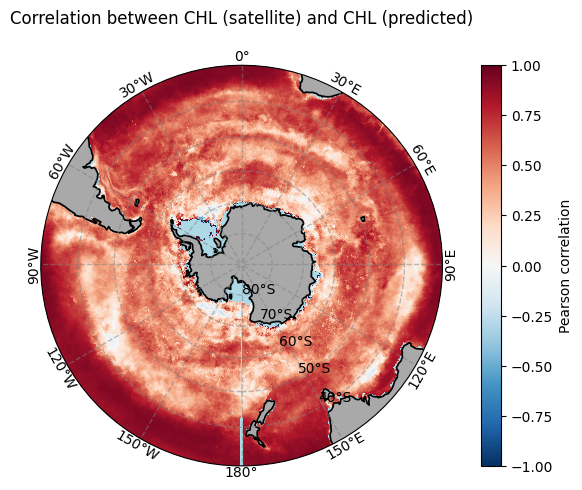

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
antarctic_map(ax)
# Plot using xarray's built-in plotting with matplotlib axis
corr_map.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    cmap="RdBu_r",
    cbar_kwargs={'label': 'Pearson correlation'}
)

plt.title("Correlation between CHL (satellite) and CHL (predicted)", pad= 30)
plt.tight_layout()
plt.show()

## Hovmoller plot

In [38]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
import numpy as np
import colorcet as cc

def plot_chl_comparison(sat_chl, pred_chl, lon, di, basin):
    """
    Plot Hovmöller plots of satellite and predicted CHL at a specified longitude,
    and their difference.

    Parameters:
    -----------
    sat_chl : xarray.Dataset or xarray.DataArray
        Satellite CHL data with variable named 'CHL'
    pred_chl : xarray.Dataset or xarray.DataArray
        Predicted CHL data with variable named 'chloro_pred'
    elon : float
        Longitude value for extracting Hovmöller slice (e.g., 90 for 90°E)
    """
    # Extract Hovmöller slices
    sat_1d = sat_chl.sel(longitude=lon, method='nearest')
    pred_1d = pred_chl.sel(longitude=lon, method='nearest')

    # Difference
    diff = pred_1d.chloro_pred - sat_1d.CHL

    # Set color limits for CHL
    chl_min = 0.01
    chl_max = 10
    diff_min, diff_max = -1, 1  # Customize if needed

    # ---- PLOT: 3-Panel Hovmöller ----
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 10), dpi=100, constrained_layout=True)

    # Panel 1: Satellite CHL
    pcm1 = ax[0].pcolormesh(
        sat_1d.latitude, sat_1d.time, sat_1d.CHL,
        cmap=cc.cm["rainbow"], norm=colors.LogNorm(vmin=chl_min, vmax=chl_max), shading='auto'
    )
    ax[0].set_title(f"Satellite CHL at {lon}°{di}")
    ax[0].set_ylabel("Time")
    ax[0].set_xlabel("Latitude")
    fig.colorbar(pcm1, ax=ax[0], orientation='vertical', pad=0.02, label='mg/m³')

    # Panel 2: Predicted CHL
    pcm2 = ax[1].pcolormesh(
        pred_1d.latitude, pred_1d.time, pred_1d.chloro_pred,
        cmap=cc.cm["rainbow"], norm=colors.LogNorm(vmin=chl_min, vmax=chl_max), shading='auto'
    )
    ax[1].set_title(f"Predicted CHL at {lon}°{di}")
    ax[1].set_xlabel("Latitude")
    fig.colorbar(pcm2, ax=ax[1], orientation='vertical', pad=0.02, label='mg/m³')

    # Panel 3: Difference
    pcm3 = ax[2].pcolormesh(
        diff.latitude, diff.time, diff,
        cmap=cmocean.cm.balance, vmin=diff_min, vmax=diff_max, shading='auto'
    )
    ax[2].set_title("CHL Difference (Pred - Sat)")
    ax[2].set_xlabel("Latitude")
    fig.colorbar(pcm3, ax=ax[2], orientation='vertical', pad=0.02, label='mg/m³')

    for axis in ax:
        axis.grid(True, linestyle='--', color='gray', linewidth=0.5)

    plt.suptitle(f"Hovmöller Comparison at {lon}°{di}-{basin}", fontsize=14)
    plt.show()

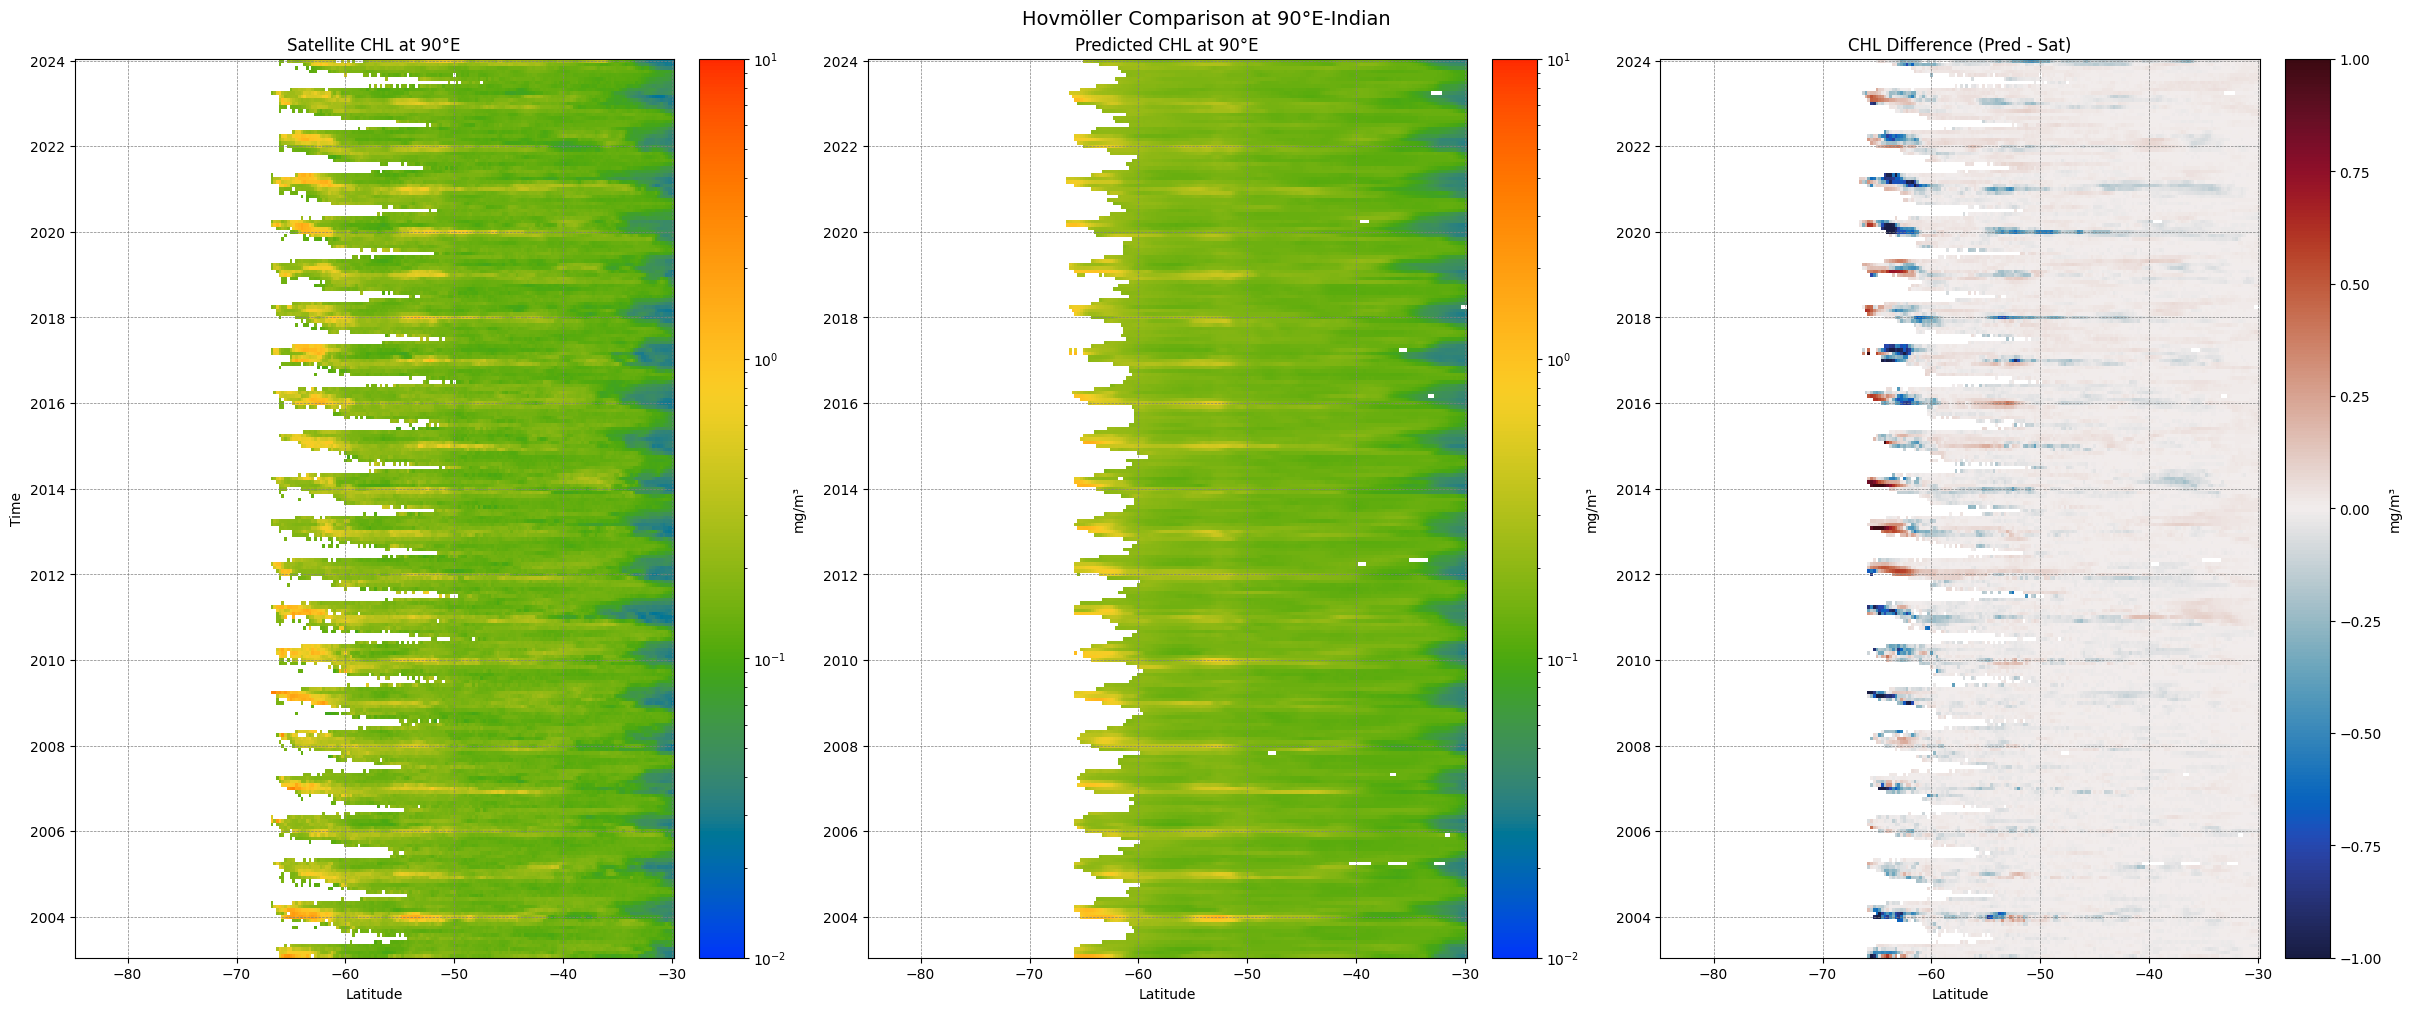

In [39]:
plot_chl_comparison(sat_chl=sat_chl, pred_chl=pred_chl, lon=90, di='E', basin='Indian')

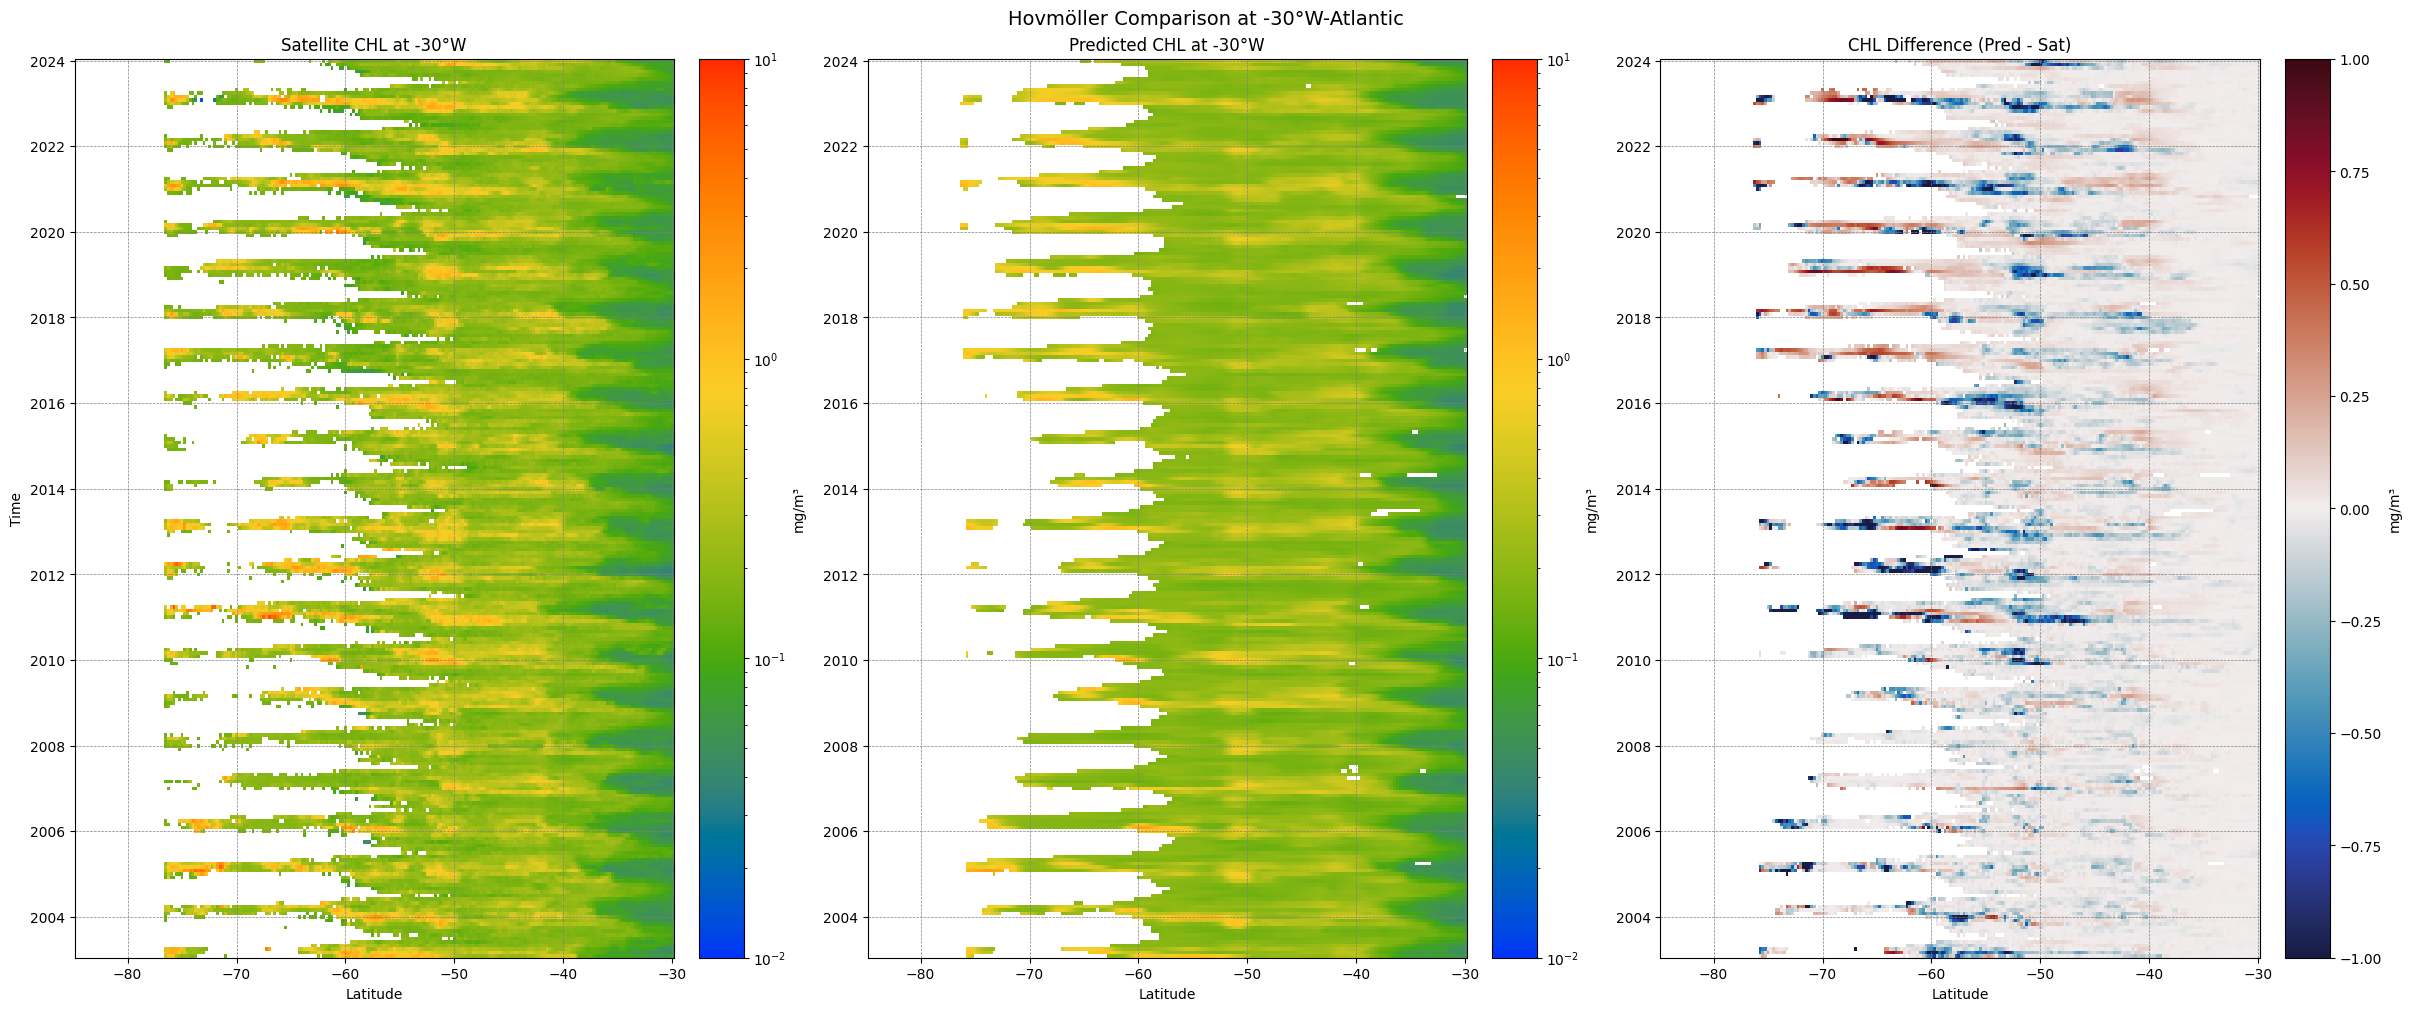

In [40]:
plot_chl_comparison(sat_chl=sat_chl, pred_chl=pred_chl, lon=-30, di='W', basin='Atlantic')

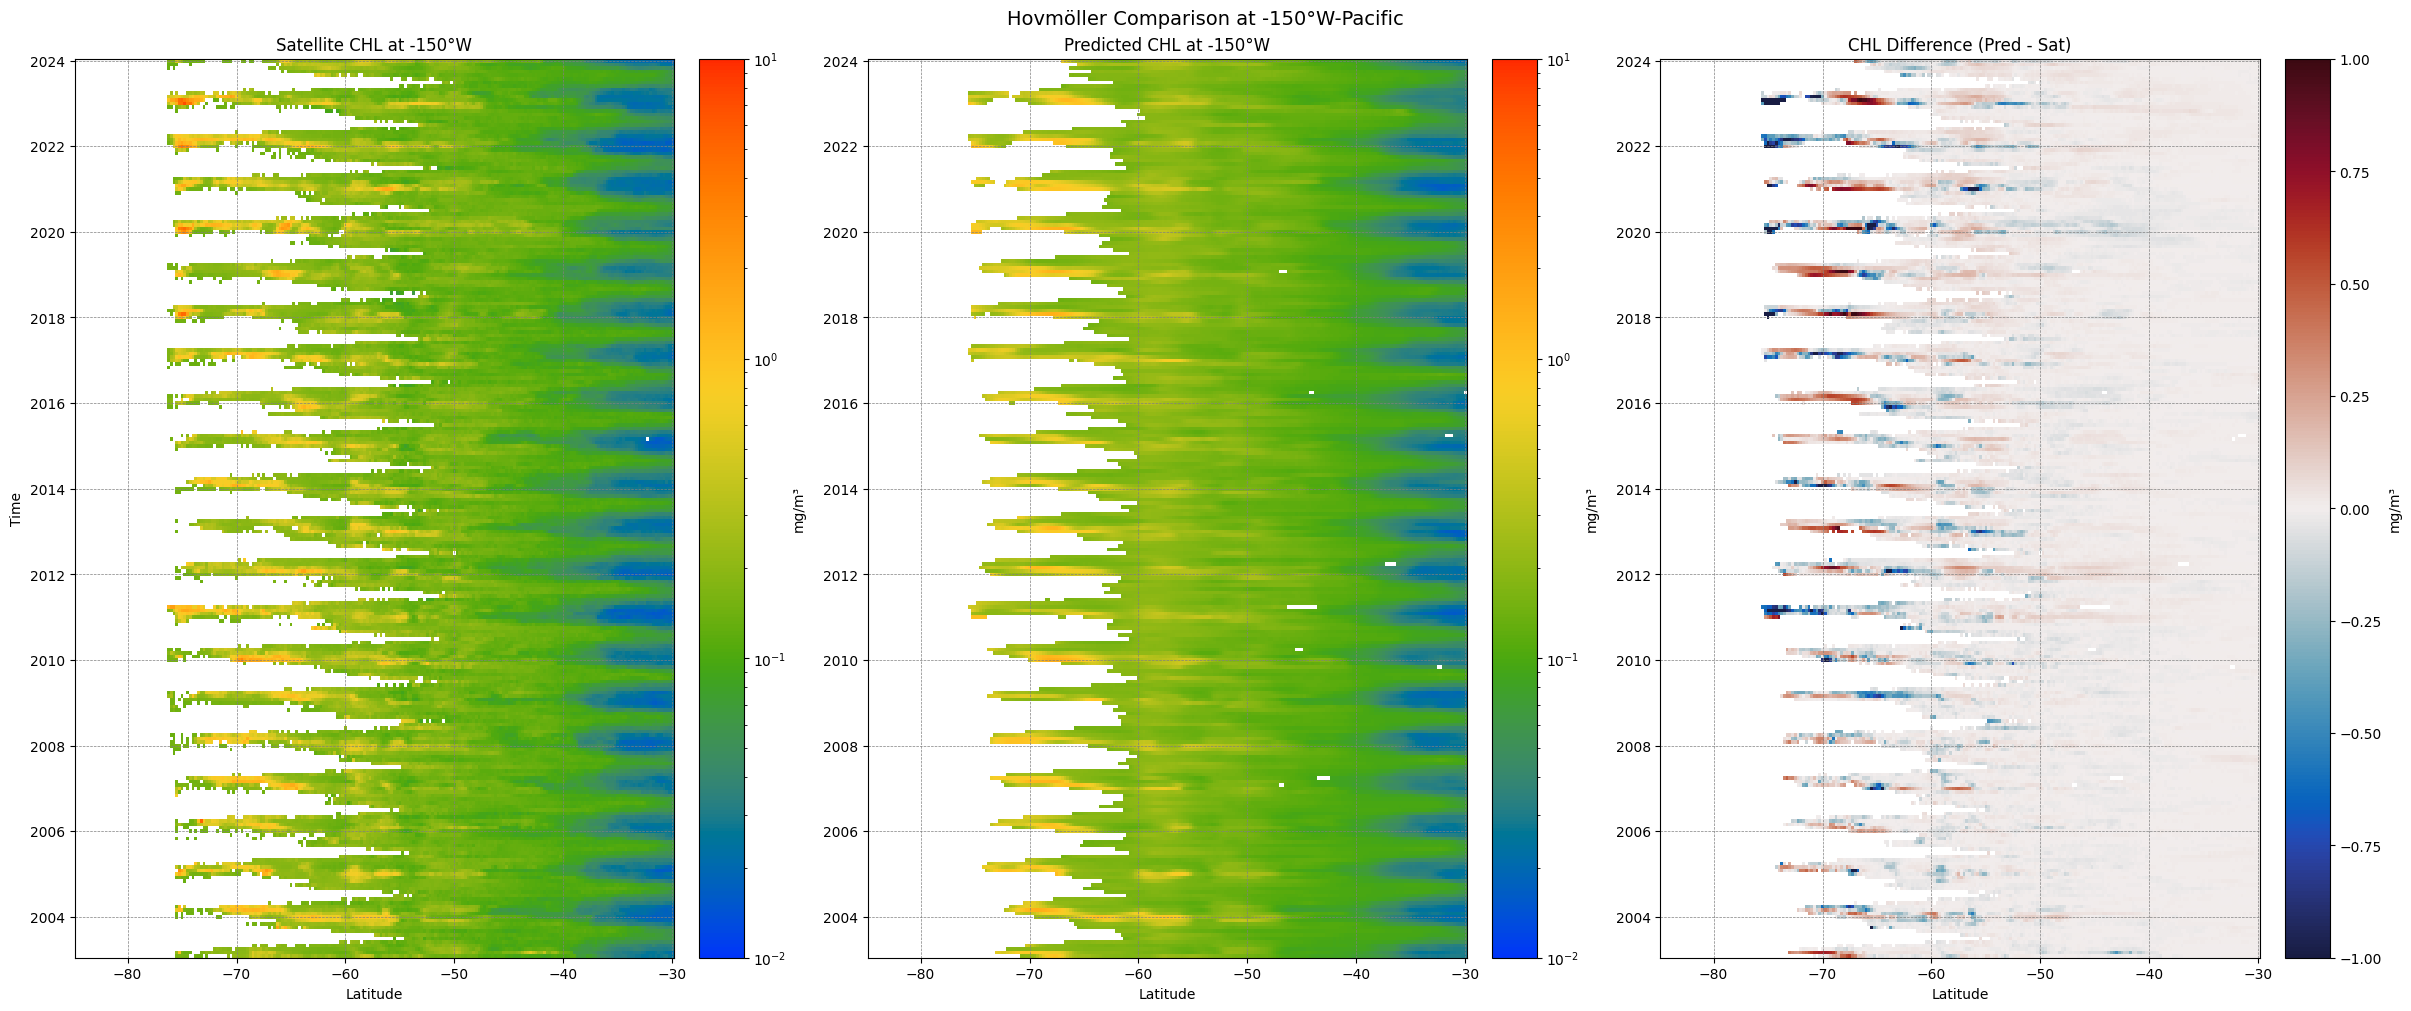

In [41]:
plot_chl_comparison(sat_chl=sat_chl, pred_chl=pred_chl, lon=-150, di='W', basin='Pacific')

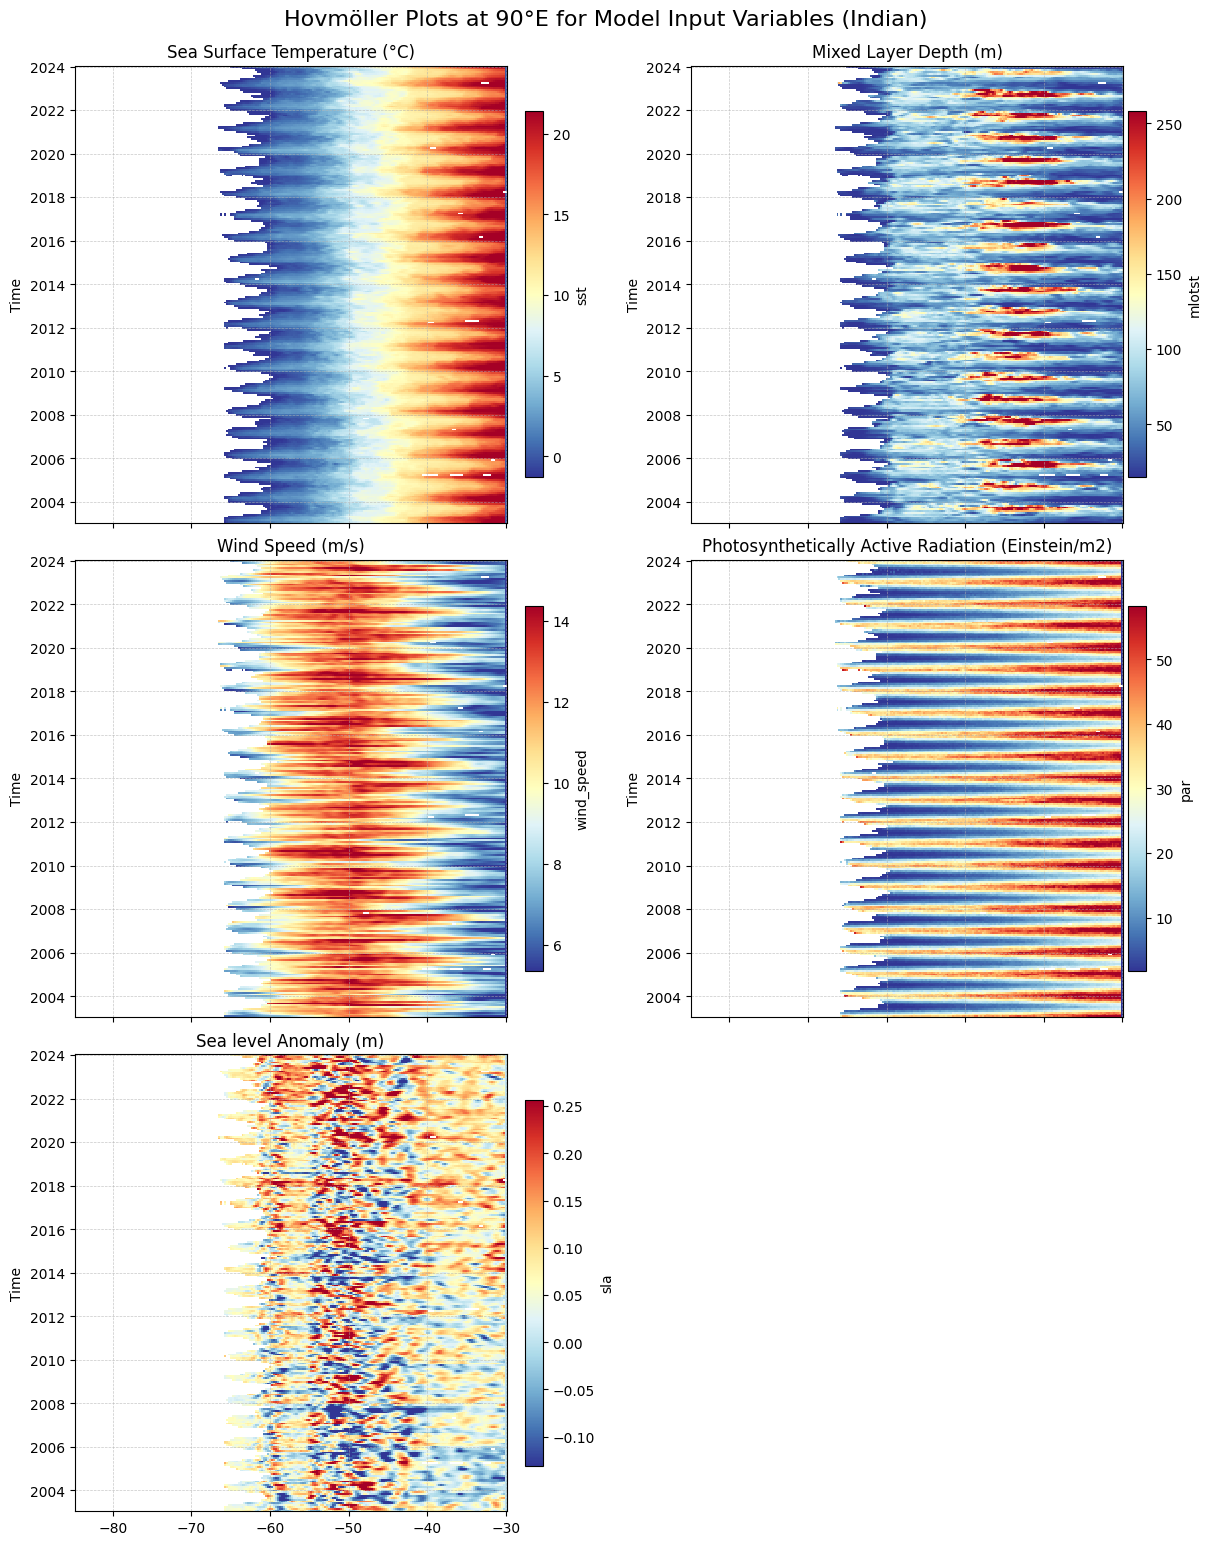

In [35]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
input_ds = xr.open_dataset("/A04/so_data/Trend_paper/CNN_training/obs/input_ds_sst_mld_ws_par_sla_masked_time.nc")

# Variable names to plot
var_names = ['sst', 'mlotst', 'wind_speed', 'par', 'sla']
titles = ['Sea Surface Temperature (°C)', 'Mixed Layer Depth (m)', 'Wind Speed (m/s)', 'Photosynthetically Active Radiation (Einstein/m2)', 'Sea level Anomaly (m)']
lon_90E = 90  # Longitude 90°E

# Set up the 2x2 figure
fig, axes = plt.subplots(3, 2, figsize=(12, 15), sharex=True, constrained_layout=True)
axes = axes.flatten()  # <-- flatten 2x2 array to 1D array of axes

for i, var in enumerate(var_names):
    # Extract variable at 90°E
    var_data = input_ds[var].sel(longitude=lon_90E, method='nearest')

    # Color limits
    vmin = np.nanpercentile(var_data, 2)
    vmax = np.nanpercentile(var_data, 98)

    # Plot Hovmöller diagram
    pcm = axes[i].pcolormesh(var_data.latitude, var_data.time, var_data.transpose('time', 'latitude'),
                             cmap='RdYlBu_r', vmin=vmin, vmax=vmax, shading='auto')

    axes[i].set_title(titles[i])
    axes[i].set_ylabel("Time")
    axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    cbar = fig.colorbar(pcm, ax=axes[i], orientation='vertical', pad=0.01, shrink=0.8)
    cbar.ax.set_ylabel(var)

axes[-1].remove()
plt.suptitle("Hovmöller Plots at 90°E for Model Input Variables (Indian)", fontsize=16, y=1.02)
plt.show()

In [ ]:
var_data.latitude[0:155]

In [44]:
sat_sel = sat_chl.sel(longitude=slice(90, 100), latitude=slice(-50, -60))
sat_sel

<xarray.Dataset> Size: 5MB
Dimensions:    (time: 252, latitude: 41, longitude: 41)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2003-01-31 2003-02-28 ... 2023-12-31
  * latitude   (latitude) float64 328B -50.0 -50.25 -50.5 ... -59.5 -59.75 -60.0
  * longitude  (longitude) float64 328B 90.0 90.25 90.5 ... 99.5 99.75 100.0
    mask       (time, latitude, longitude) float64 3MB ...
Data variables:
    CHL        (time, latitude, longitude) float32 2MB ...
Attributes:
    regrid_method:  bilinear

### Scatter plot

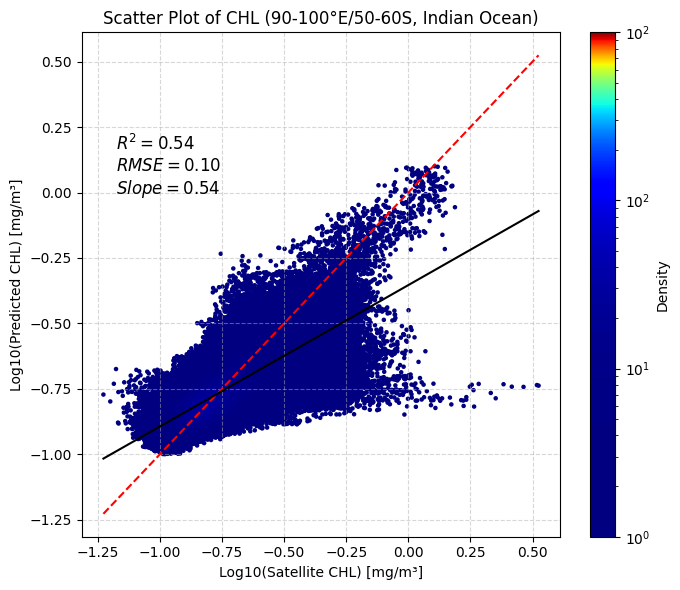

In [45]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress
from sklearn.metrics import mean_squared_error

# --- Select region from 30E to 150E ---
sat_sel = sat_chl.sel(longitude=slice(90, 100), latitude=slice(-50, -60))
pred_sel = pred_chl.sel(longitude=slice(90, 100), latitude=slice(-50, -60))

# Flatten and clean
sat_flat = sat_sel.CHL.values.flatten()
pred_flat = pred_sel.chloro_pred.values.flatten()
mask = ~np.isnan(sat_flat) & ~np.isnan(pred_flat)
sat_clean = sat_flat[mask]
pred_clean = pred_flat[mask]
# Log transform
sat_log = np.log10(sat_clean + 1e-6)
pred_log = np.log10(pred_clean + 1e-6)

# --- Compute stats ---
slope, intercept, r_value, p_value, std_err = linregress(sat_log, pred_log)
rmse = np.sqrt(mean_squared_error(sat_log, pred_log))
r2 = r_value**2
# --- Density estimation ---
xy = np.vstack([sat_log, pred_log])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_sorted, y_sorted, z_sorted = sat_log[idx], pred_log[idx], z[idx]
# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=5, cmap='jet', norm=plt.Normalize(vmin=1e0, vmax=1e3))

# 1:1 Line
min_val = min(sat_log.min(), pred_log.min())
max_val = max(sat_log.max(), pred_log.max())
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 Line')

# Regression Line
x_fit = np.array([min_val, max_val])
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, color='black', linestyle='-', label='Regression Line')

# Text box
textstr = '\n'.join((
    r'$R^2=%.2f$' % r2,
    r'$RMSE=%.2f$' % rmse,
    r'$Slope=%.2f$' % slope,
))
plt.text(min_val + 0.05, max_val - 0.3, textstr, fontsize=12, va='top')

# Formatting
plt.xlabel("Log10(Satellite CHL) [mg/m³]")
plt.ylabel("Log10(Predicted CHL) [mg/m³]")
plt.title("Scatter Plot of CHL (90-100°E/50-60S, Indian Ocean)")

cb = fig.colorbar(sc, ax=ax)
cb.set_label("Density")
cb.ax.set_yscale('log')
cb.set_ticks([1e0, 1e1, 1e2, 1e3])
cb.ax.set_yticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^2$'])

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress
from sklearn.metrics import mean_squared_error

# --- Select region from 30E to 150E ---
sat_sel = sat_chl.sel(longitude=slice(-105, -100))
pred_sel = pred_chl.sel(longitude=slice(-105, -100))

# Flatten and clean
sat_flat = sat_sel.CHL.values.flatten()
pred_flat = pred_sel.chloro_pred.values.flatten()
mask = ~np.isnan(sat_flat) & ~np.isnan(pred_flat)
sat_clean = sat_flat[mask]
pred_clean = pred_flat[mask]
# Log transform
sat_log = np.log10(sat_clean + 1e-6)
pred_log = np.log10(pred_clean + 1e-6)

# --- Compute stats ---
slope, intercept, r_value, p_value, std_err = linregress(sat_log, pred_log)
rmse = np.sqrt(mean_squared_error(sat_log, pred_log))
r2 = r_value**2
# --- Density estimation ---#
xy = np.vstack([sat_log, pred_log])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_sorted, y_sorted, z_sorted = sat_log[idx], pred_log[idx], z[idx]
# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=5, cmap='jet', norm=plt.Normalize(vmin=1e0, vmax=1e3))

# 1:1 Line
min_val = min(sat_log.min(), pred_log.min())
max_val = max(sat_log.max(), pred_log.max())
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 Line')

# Regression Line
x_fit = np.array([min_val, max_val])
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, color='black', linestyle='-', label='Regression Line')

# Text box
textstr = '\n'.join((
    r'$R^2=%.2f$' % r2,
    r'$RMSE=%.2f$' % rmse,
    r'$Slope=%.2f$' % slope,
))
plt.text(min_val + 0.05, max_val - 0.3, textstr, fontsize=12, va='top')

# Formatting
plt.xlabel("Log10(Satellite CHL) [mg/m³]")
plt.ylabel("Log10(Predicted CHL) [mg/m³]")
plt.title("Scatter Plot of CHL (100°W to 105°W, Pacific Ocean)")

cb = fig.colorbar(sc, ax=ax)
cb.set_label("Density")
cb.ax.set_yscale('log')
cb.set_ticks([1e0, 1e1, 1e2, 1e3])
cb.ax.set_yticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress
from sklearn.metrics import mean_squared_error

# --- Select region from 30E to 150E ---
sat_sel = sat_chl.sel(longitude=slice(-30, -25))
pred_sel = pred_chl.sel(longitude=slice(-30, -25))

# Flatten and clean
sat_flat = sat_sel.CHL.values.flatten()
pred_flat = pred_sel.chloro_pred.values.flatten()
mask = ~np.isnan(sat_flat) & ~np.isnan(pred_flat)
sat_clean = sat_flat[mask]
pred_clean = pred_flat[mask]
# Log transform
sat_log = np.log10(sat_clean + 1e-6)
pred_log = np.log10(pred_clean + 1e-6)

# --- Compute stats ---
slope, intercept, r_value, p_value, std_err = linregress(sat_log, pred_log)
rmse = np.sqrt(mean_squared_error(sat_log, pred_log))
r2 = r_value**2
# --- Density estimation ---#
xy = np.vstack([sat_log, pred_log])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_sorted, y_sorted, z_sorted = sat_log[idx], pred_log[idx], z[idx]
# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=5, cmap='jet', norm=plt.Normalize(vmin=1e0, vmax=1e3))

# 1:1 Line
min_val = min(sat_log.min(), pred_log.min())
max_val = max(sat_log.max(), pred_log.max())
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 Line')

# Regression Line
x_fit = np.array([min_val, max_val])
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, color='black', linestyle='-', label='Regression Line')

# Text box
textstr = '\n'.join((
    r'$R^2=%.2f$' % r2,
    r'$RMSE=%.2f$' % rmse,
    r'$Slope=%.2f$' % slope,
))
plt.text(min_val + 0.05, max_val - 0.3, textstr, fontsize=12, va='top')

# Formatting
plt.xlabel("Log10(Satellite CHL) [mg/m³]")
plt.ylabel("Log10(Predicted CHL) [mg/m³]")
plt.title("Scatter Plot of CHL (25°W to 30°W, Atlantic Ocean)")

cb = fig.colorbar(sc, ax=ax)
cb.set_label("Density")
cb.ax.set_yscale('log')
cb.set_ticks([1e0, 1e1, 1e2, 1e3])
cb.ax.set_yticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

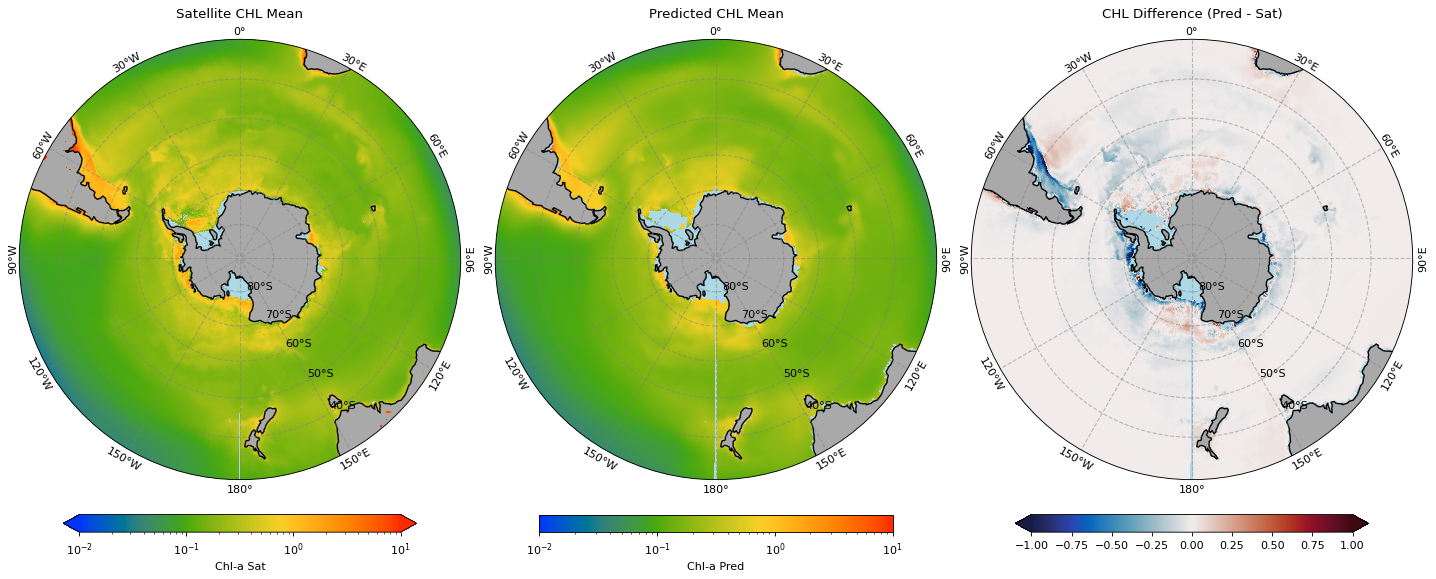

In [46]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
import colorcet as cc

# Load and rename

y_test = xr.open_dataset("/A04/so_data/Trend_paper/CNN_training/obs/Same_grid_CHL_25km_masked.nc")
y_test = y_test.rename({'CHL': 'chloro'})

y_pred = xr.open_mfdataset("/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-23/*Chloro_pred/Chloro_pred_*.nc").load()

# Compute time-averaged chlorophyll
sat_chloro_mean = y_test.chloro.mean(dim="time")
pred_chloro_mean = y_pred.chloro_pred.mean(dim="time")

# Set color maps
cm = cc.cm["rainbow"]

# Plot mean CHL and difference
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,9), dpi=80, facecolor='w', edgecolor='k', subplot_kw={'projection': ccrs.SouthPolarStereo()})
for a in ax:
    antarctic_map(a)
# Plot satellite mean
sat_chloro_mean.plot(ax=ax[0], cmap=cm, norm=colors.LogNorm(vmin=0.01, vmax=10), transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "Chl-a Sat"})
ax[0].set_title("Satellite CHL Mean",  pad=20)

# Plot predicted mean
pred_chloro_mean.plot(ax=ax[1], cmap=cm, norm=colors.LogNorm(vmin=0.01, vmax=10), transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "Chl-a Pred"})
ax[1].set_title("Predicted CHL Mean",  pad=20)

# Plot difference
(pred_chloro_mean - sat_chloro_mean).plot(ax=ax[2], cmap=cmocean.cm.balance, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8})
ax[2].set_title("CHL Difference (Pred - Sat)", pad=20)

plt.tight_layout()
plt.show()

In [52]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
# Define the color map
color_values = [
    [147,0,108], [111,0,144], [72,0,183], [33,0,222], [0,10,255], [0,74,255],
    [0,144,255], [0,213,255], [0,255,215], [0,255,119], [0,255,15], [96,255,0],
    [200,255,0], [255,235,0], [255,183,0], [255,131,0], [255,79,0], [255,31,0],
    [230,0,0], [165,0,0], [105,0,0]
]
sample_values = [0.0405927390978, 0.08511153517746066, 0.1018493234759939,
                 0.143259381777070279, 0.1647886418593687446, 0.1831451603621097,
                 0.20029112852033921, 0.213464383750438, 0.2364794954661175,
                 0.250882852380362497, 0.2604533847704508146, 0.276561070836975002,
                 0.297086359751581525, 0.3261169989723918, 0.33049610500045872,
                 0.5011261431529367, 0.64106633340013, 0.711407543621453,
                 0.865646919990738, 0.912969492356, 1.0]
cmap = colors.ListedColormap(np.array(color_values)/255.0)
norm = colors.BoundaryNorm(sample_values, len(sample_values))

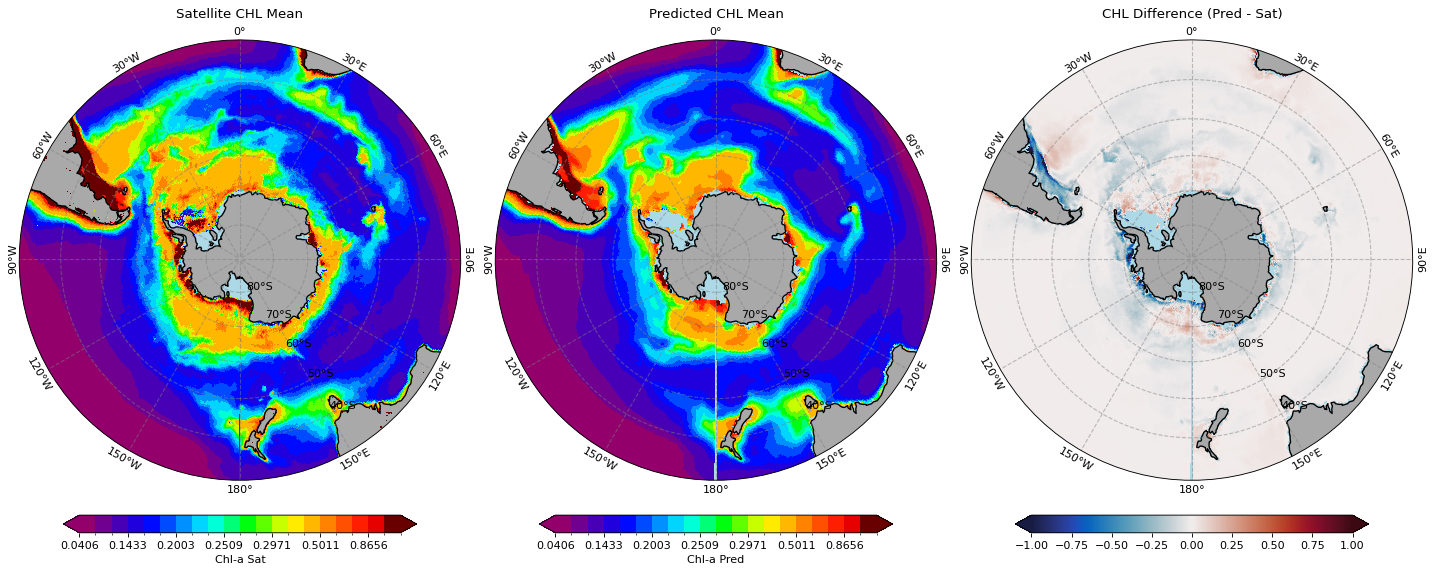

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,9), dpi=80, facecolor='w', edgecolor='k', subplot_kw={'projection': ccrs.SouthPolarStereo()})
for a in ax:
    antarctic_map(a)
# Plot satellite mean
sat_chloro_mean.plot(ax=ax[0], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "Chl-a Sat"})
ax[0].set_title("Satellite CHL Mean",  pad=20)

# Plot predicted mean
pred_chloro_mean.plot(ax=ax[1], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "Chl-a Pred"})
ax[1].set_title("Predicted CHL Mean",  pad=20)

# Plot difference
(pred_chloro_mean - sat_chloro_mean).plot(ax=ax[2], cmap=cmocean.cm.balance, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8})
ax[2].set_title("CHL Difference (Pred - Sat)", pad=20)

plt.tight_layout()
plt.show()

In [54]:
sat_chloro_mean = y_test.mean(dim = ("time"))
pred_chloro_mean = y_pred.mean(dim = ["time"])

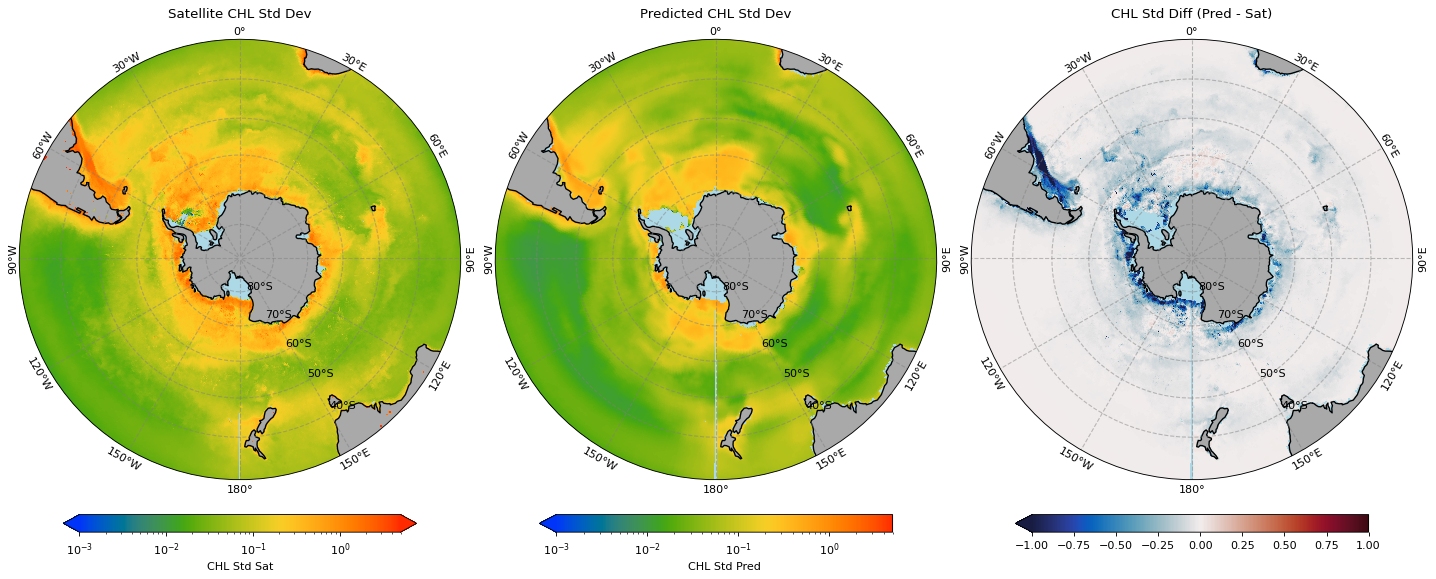

In [56]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
import colorcet as cc
import cartopy.crs as ccrs

# Compute std deviation
sat_chloro_std = y_test.chloro.std(dim="time")
pred_chloro_std = y_pred.chloro_pred.std(dim="time")

# Set colormap
cm = cc.cm["rainbow"]

# Create plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 9), dpi=80, facecolor='w', edgecolor='k',
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})

for a in ax:
    antarctic_map(a)  # Assuming you already defined this to add land, coastlines, etc.

# Satellite std plot
sat_chloro_std.plot(ax=ax[0], cmap=cm, norm=colors.LogNorm(vmin=0.001, vmax=5), transform=ccrs.PlateCarree(),
                    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "CHL Std Sat"})
ax[0].set_title("Satellite CHL Std Dev", pad=20)

# Prediction std plot
pred_chloro_std.plot(ax=ax[1], cmap=cm, norm=colors.LogNorm(vmin=0.001, vmax=5), transform=ccrs.PlateCarree(),
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "CHL Std Pred"})
ax[1].set_title("Predicted CHL Std Dev", pad=20)

# Difference plot
(pred_chloro_std - sat_chloro_std).plot(ax=ax[2], cmap=cmocean.cm.balance, vmin=-1, vmax=1, transform=ccrs.PlateCarree(),
                                        cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8})
ax[2].set_title("CHL Std Diff (Pred - Sat)", pad=20)

plt.tight_layout()
plt.show()

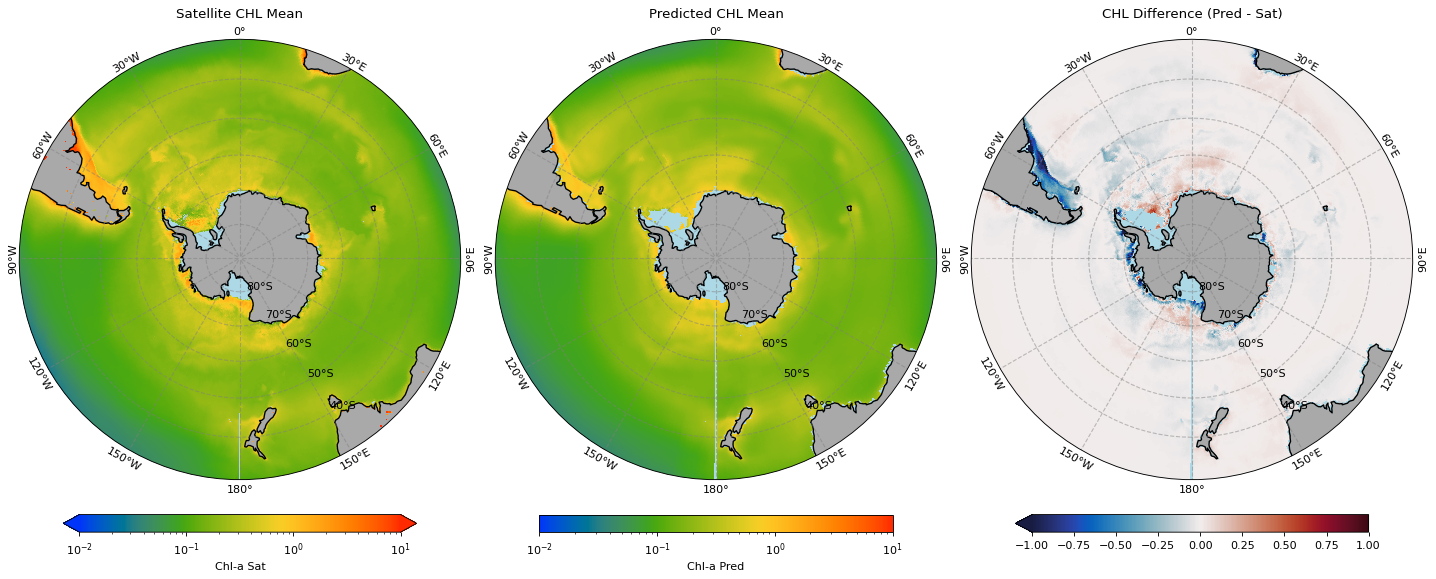

In [57]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
import colorcet as cc

# Load and rename

y_test = xr.open_dataset("/A04/so_data/Trend_paper/CNN_training/obs/Same_grid_CHL_25km_masked.nc")
y_test = y_test.rename({'CHL': 'chloro'})

y_pred = xr.open_mfdataset("/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-22/*Chloro_pred/Chloro_pred_*.nc").load()

# Compute time-averaged chlorophyll
sat_chloro_mean = y_test.chloro.mean(dim="time")
pred_chloro_mean = y_pred.chloro_pred.mean(dim="time")

# Set color maps
cm = cc.cm["rainbow"]

# Plot mean CHL and difference
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,9), dpi=80, facecolor='w', edgecolor='k', subplot_kw={'projection': ccrs.SouthPolarStereo()})
for a in ax:
    antarctic_map(a)
# Plot satellite mean
sat_chloro_mean.plot(ax=ax[0], cmap=cm, norm=colors.LogNorm(vmin=0.01, vmax=10), transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "Chl-a Sat"})
ax[0].set_title("Satellite CHL Mean",  pad=20)

# Plot predicted mean
pred_chloro_mean.plot(ax=ax[1], cmap=cm, norm=colors.LogNorm(vmin=0.01, vmax=10), transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "Chl-a Pred"})
ax[1].set_title("Predicted CHL Mean",  pad=20)

# Plot difference
(pred_chloro_mean - sat_chloro_mean).plot(ax=ax[2], cmap=cmocean.cm.balance, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8})
ax[2].set_title("CHL Difference (Pred - Sat)", pad=20)

plt.tight_layout()
plt.show()

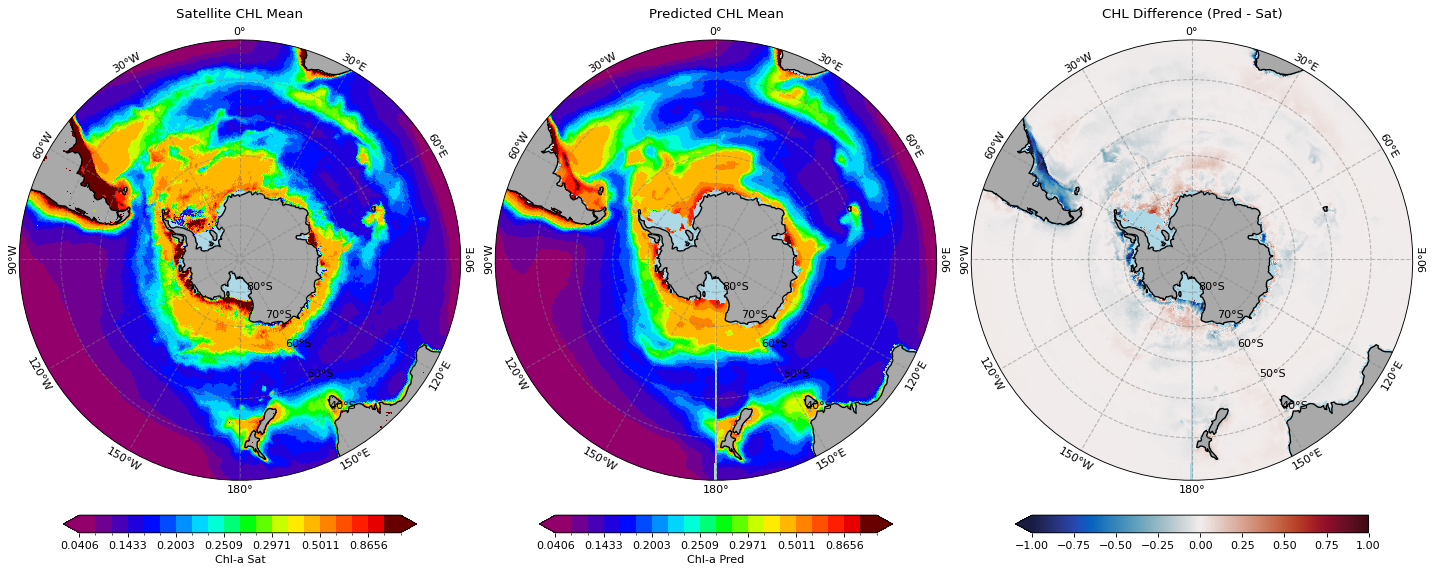

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,9), dpi=80, facecolor='w', edgecolor='k', subplot_kw={'projection': ccrs.SouthPolarStereo()})
for a in ax:
    antarctic_map(a)
# Plot satellite mean
sat_chloro_mean.plot(ax=ax[0], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "Chl-a Sat"})
ax[0].set_title("Satellite CHL Mean",  pad=20)

# Plot predicted mean
pred_chloro_mean.plot(ax=ax[1], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "Chl-a Pred"})
ax[1].set_title("Predicted CHL Mean",  pad=20)

# Plot difference
(pred_chloro_mean - sat_chloro_mean).plot(ax=ax[2], cmap=cmocean.cm.balance, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8})
ax[2].set_title("CHL Difference (Pred - Sat)", pad=20)

plt.tight_layout()
plt.show()

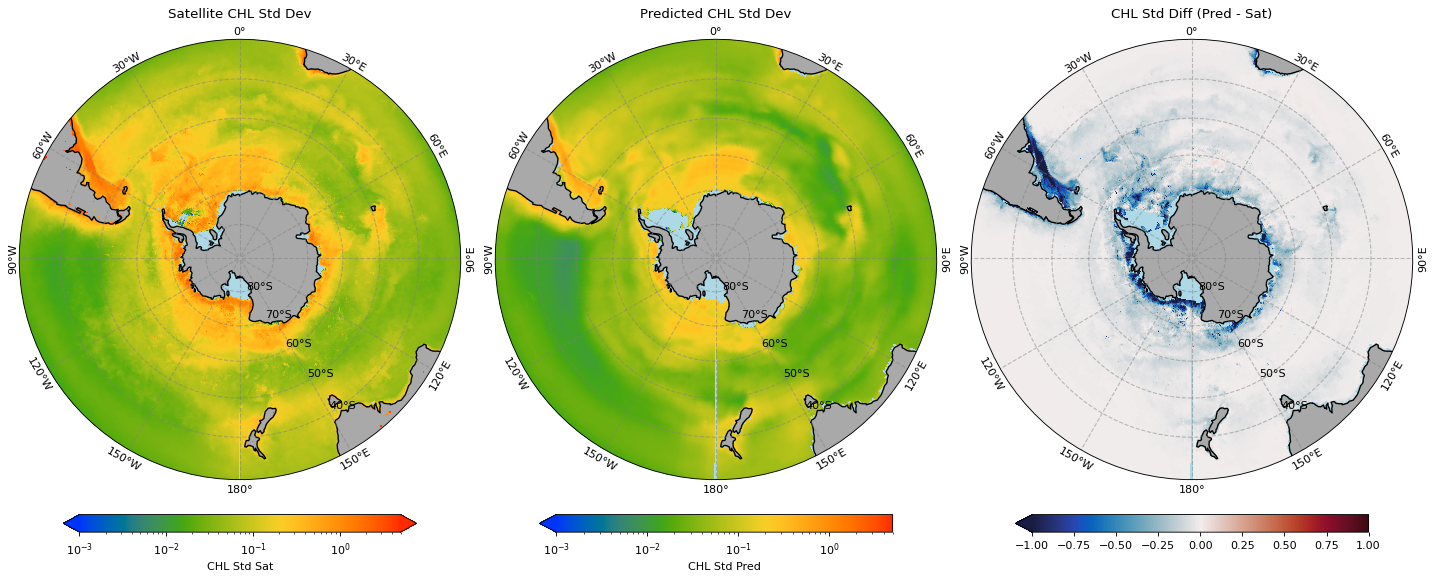

In [59]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
import colorcet as cc
import cartopy.crs as ccrs

# Compute std deviation
sat_chloro_std = y_test.chloro.std(dim="time")
pred_chloro_std = y_pred.chloro_pred.std(dim="time")

# Set colormap
cm = cc.cm["rainbow"]

# Create plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 9), dpi=80, facecolor='w', edgecolor='k',
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})

for a in ax:
    antarctic_map(a)  # Assuming you already defined this to add land, coastlines, etc.

# Satellite std plot
sat_chloro_std.plot(ax=ax[0], cmap=cm, norm=colors.LogNorm(vmin=0.001, vmax=5), transform=ccrs.PlateCarree(),
                    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "CHL Std Sat"})
ax[0].set_title("Satellite CHL Std Dev", pad=20)

# Prediction std plot
pred_chloro_std.plot(ax=ax[1], cmap=cm, norm=colors.LogNorm(vmin=0.001, vmax=5), transform=ccrs.PlateCarree(),
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "CHL Std Pred"})
ax[1].set_title("Predicted CHL Std Dev", pad=20)

# Difference plot
(pred_chloro_std - sat_chloro_std).plot(ax=ax[2], cmap=cmocean.cm.balance, vmin=-1, vmax=1, transform=ccrs.PlateCarree(),
                                        cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8})
ax[2].set_title("CHL Std Diff (Pred - Sat)", pad=20)

plt.tight_layout()
plt.show()

#### Scatter plot of Training and test period 

In [68]:
### Training 2003-2010
sat_chl=xr.open_dataset("/A04/so_data/Trend_paper/CNN_training/obs/Same_grid_CHL_25km_masked.nc")
pred_chl= xr.open_mfdataset("/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-23/*Chloro_pred/Chloro_pred_*.nc").load()

In [69]:
sat_chl=sat_chl.sel(time=slice("2011-01-31", "2020-12-31"))
pred_chl=pred_chl.sel(time=slice("2011-01-31", "2020-12-31"))

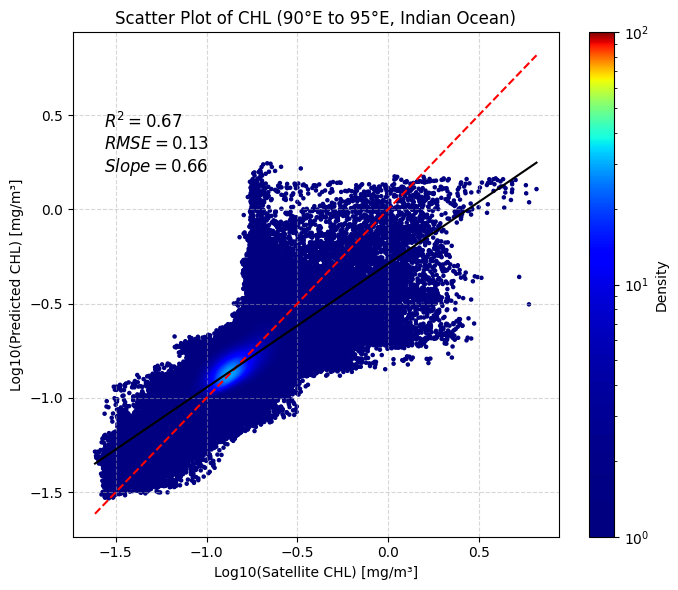

In [70]:
# --- Select region from 30E to 150E ---
sat_sel = sat_chl.sel(longitude=slice(90, 95))
pred_sel = pred_chl.sel(longitude=slice(90, 95))

# Flatten and clean
sat_flat = sat_sel.CHL.values.flatten()
pred_flat = pred_sel.chloro_pred.values.flatten()
mask = ~np.isnan(sat_flat) & ~np.isnan(pred_flat)
sat_clean = sat_flat[mask]
pred_clean = pred_flat[mask]
# Log transform
sat_log = np.log10(sat_clean + 1e-6)
pred_log = np.log10(pred_clean + 1e-6)

# --- Compute stats ---
slope, intercept, r_value, p_value, std_err = linregress(sat_log, pred_log)
rmse = np.sqrt(mean_squared_error(sat_log, pred_log))
r2 = r_value**2
# --- Density estimation ---
xy = np.vstack([sat_log, pred_log])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_sorted, y_sorted, z_sorted = sat_log[idx], pred_log[idx], z[idx]
# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=5, cmap='jet', norm=plt.Normalize(vmin=1e0, vmax=1e2))

# 1:1 Line
min_val = min(sat_log.min(), pred_log.min())
max_val = max(sat_log.max(), pred_log.max())
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 Line')

# Regression Line
x_fit = np.array([min_val, max_val])
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, color='black', linestyle='-', label='Regression Line')

# Text box
textstr = '\n'.join((
    r'$R^2=%.2f$' % r2,
    r'$RMSE=%.2f$' % rmse,
    r'$Slope=%.2f$' % slope,
))
plt.text(min_val + 0.05, max_val - 0.3, textstr, fontsize=12, va='top')

# Formatting
plt.xlabel("Log10(Satellite CHL) [mg/m³]")
plt.ylabel("Log10(Predicted CHL) [mg/m³]")
plt.title("Scatter Plot of CHL (90°E to 95°E, Indian Ocean)")

cb = fig.colorbar(sc, ax=ax)
cb.set_label("Density")
cb.ax.set_yscale('log')
cb.set_ticks([1e0, 1e1, 1e2])
cb.ax.set_yticklabels([r'$10^0$', r'$10^1$', r'$10^2$'])

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

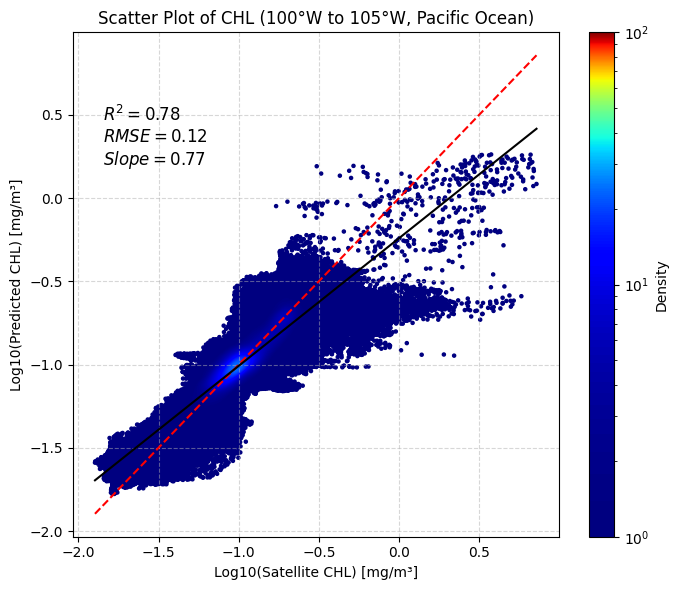

In [71]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress
from sklearn.metrics import mean_squared_error

# --- Select region from 30E to 150E ---
sat_sel = sat_chl.sel(longitude=slice(-105, -100))
pred_sel = pred_chl.sel(longitude=slice(-105, -100))

# Flatten and clean
sat_flat = sat_sel.CHL.values.flatten()
pred_flat = pred_sel.chloro_pred.values.flatten()
mask = ~np.isnan(sat_flat) & ~np.isnan(pred_flat)
sat_clean = sat_flat[mask]
pred_clean = pred_flat[mask]
# Log transform
sat_log = np.log10(sat_clean + 1e-6)
pred_log = np.log10(pred_clean + 1e-6)

# --- Compute stats ---
slope, intercept, r_value, p_value, std_err = linregress(sat_log, pred_log)
rmse = np.sqrt(mean_squared_error(sat_log, pred_log))
r2 = r_value**2
# --- Density estimation ---#
xy = np.vstack([sat_log, pred_log])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_sorted, y_sorted, z_sorted = sat_log[idx], pred_log[idx], z[idx]
# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=5, cmap='jet', norm=plt.Normalize(vmin=1e0, vmax=1e2))

# 1:1 Line
min_val = min(sat_log.min(), pred_log.min())
max_val = max(sat_log.max(), pred_log.max())
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 Line')

# Regression Line
x_fit = np.array([min_val, max_val])
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, color='black', linestyle='-', label='Regression Line')

# Text box
textstr = '\n'.join((
    r'$R^2=%.2f$' % r2,
    r'$RMSE=%.2f$' % rmse,
    r'$Slope=%.2f$' % slope,
))
plt.text(min_val + 0.05, max_val - 0.3, textstr, fontsize=12, va='top')

# Formatting
plt.xlabel("Log10(Satellite CHL) [mg/m³]")
plt.ylabel("Log10(Predicted CHL) [mg/m³]")
plt.title("Scatter Plot of CHL (100°W to 105°W, Pacific Ocean)")

cb = fig.colorbar(sc, ax=ax)
cb.set_label("Density")
cb.ax.set_yscale('log')
cb.set_ticks([1e0, 1e1, 1e2])
cb.ax.set_yticklabels([r'$10^0$', r'$10^1$', r'$10^2$'])

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

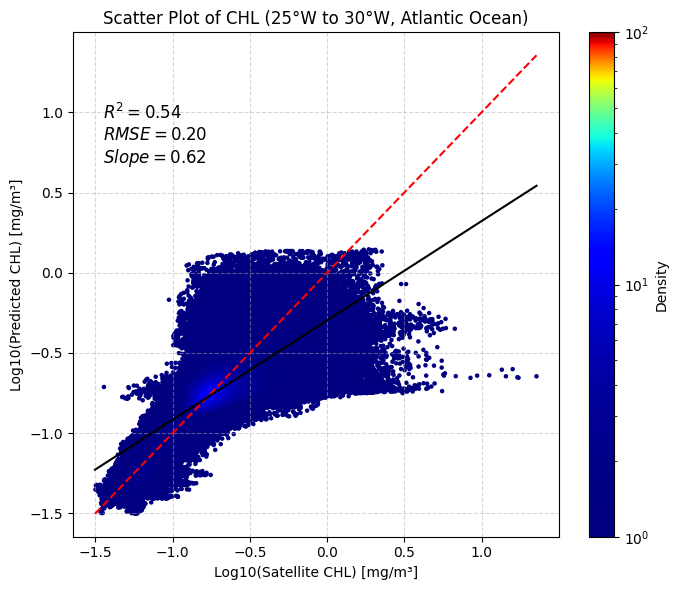

In [72]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress
from sklearn.metrics import mean_squared_error

# --- Select region from 30E to 150E ---
sat_sel = sat_chl.sel(longitude=slice(-30, -25))
pred_sel = pred_chl.sel(longitude=slice(-30, -25))

# Flatten and clean
sat_flat = sat_sel.CHL.values.flatten()
pred_flat = pred_sel.chloro_pred.values.flatten()
mask = ~np.isnan(sat_flat) & ~np.isnan(pred_flat)
sat_clean = sat_flat[mask]
pred_clean = pred_flat[mask]
# Log transform
sat_log = np.log10(sat_clean + 1e-6)
pred_log = np.log10(pred_clean + 1e-6)

# --- Compute stats ---
slope, intercept, r_value, p_value, std_err = linregress(sat_log, pred_log)
rmse = np.sqrt(mean_squared_error(sat_log, pred_log))
r2 = r_value**2
# --- Density estimation ---#
xy = np.vstack([sat_log, pred_log])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_sorted, y_sorted, z_sorted = sat_log[idx], pred_log[idx], z[idx]
# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=5, cmap='jet', norm=plt.Normalize(vmin=1e0, vmax=1e2))

# 1:1 Line
min_val = min(sat_log.min(), pred_log.min())
max_val = max(sat_log.max(), pred_log.max())
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 Line')

# Regression Line
x_fit = np.array([min_val, max_val])
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, color='black', linestyle='-', label='Regression Line')

# Text box
textstr = '\n'.join((
    r'$R^2=%.2f$' % r2,
    r'$RMSE=%.2f$' % rmse,
    r'$Slope=%.2f$' % slope,
))
plt.text(min_val + 0.05, max_val - 0.3, textstr, fontsize=12, va='top')

# Formatting
plt.xlabel("Log10(Satellite CHL) [mg/m³]")
plt.ylabel("Log10(Predicted CHL) [mg/m³]")
plt.title("Scatter Plot of CHL (25°W to 30°W, Atlantic Ocean)")

cb = fig.colorbar(sc, ax=ax)
cb.set_label("Density")
cb.ax.set_yscale('log')
cb.set_ticks([1e0, 1e1, 1e2])
cb.ax.set_yticklabels([r'$10^0$', r'$10^1$', r'$10^2$'])

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()